In [1]:
import numpy as np
import pandas as pd
from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import re
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 100
seed = 6622

c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('./data/disaster_tweets/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df.sample(15)

,id,keyword,location,text,target
2971,4268,drowning,scandinavia,don't you dare play the victim when I've been drowning for years.,0
2443,3508,derailment,NaN,#news Madhya Pradesh Train Derailment: Village Youth Saved Many Lives http://t.co/fcTrAWJcYL #ti...,1
2921,4200,drowned,NaN,Wtf this mom just drowned her child?!,1
5613,8009,refugees,NaN,This just-married Turkish couple gave 4000 Syrian refugees an incredible gift http://t.co/ibeD3x...,1
5029,7171,mudslide,NaN,RT RabidMonkeys1: Ah the unique mudslide cake ??#GBBO http://t.co/ZT5OFbiwtD,0
7541,10782,wreckage,"New Delhi,India",Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of ...,1
2647,3800,detonate,NaN,Bomb squad set to detonate backpack Antioch Tenn. theater gunman had on him officials say - @Ten...,1
1682,2427,collide,Michigan,@mattcohen4fake Gamma Ray January Worlds Collide She Waits Be Me Wave Past Perfect Reunion Lucky...,0
6090,8697,sinking,North East Unsigned Radio,#nowplaying Sinking Fast - Now or Never on North East Unsigned Radio listen at http://t.co/QymAl...,0
3355,4802,evacuated,NaN,Good thing there was actually just a legit fire in the mall and nobody evacuated!!,1


In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
tweets = df[['text']]
target = df['target']

In [7]:
target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=.25, random_state=seed
    )

In [9]:
X_train_tweets_unprocessed = X_train.copy()['text']

X_train['text'] = X_train['text'].str.lower()

In [10]:
# token_pattern = r"\b\w+'?’?\w+\b" 
token_pattern = r"\b[a-zA-Z\u00C0-\u00FF(0-9)]+'?’?[a-zA-Z\u00C0-\u00FF(0-9)]+\b"
# pattern:
    # Words with at least two letters, including words with up to one hyphen and one apostrophe.
    # Including words with accented letters.        

tokenizer = RegexpTokenizer(token_pattern)
# Sample:
X_train_sample = X_train.sample(5, random_state=seed)['text']
for tweet in X_train_sample:
    print(tweet)
    print(tokenizer.tokenize(tweet))
    print()

lets collide untill we fill the space.. ??
['lets', 'collide', 'untill', 'we', 'fill', 'the', 'space']

70 years after atomic bombs japan still struggles with war past: the anniversary of the devastation wrought b... http://t.co/1erd2fpryp
['70', 'years', 'after', 'atomic', 'bombs', 'japan', 'still', 'struggles', 'with', 'war', 'past', 'the', 'anniversary', 'of', 'the', 'devastation', 'wrought', 'http', 'co', '1erd2fpryp']

[reuters] debris confirmed from mh370; relatives hope for discovery of crash site http://t.co/dfyasvj7nf
['reuters', 'debris', 'confirmed', 'from', 'mh370', 'relatives', 'hope', 'for', 'discovery', 'of', 'crash', 'site', 'http', 'co', 'dfyasvj7nf']

#worldnews
 video: 'we're picking up bodies from water' - bbc news - home:
rescuers are searching for hundreds of.. http://t.co/6hhmbdk9yo
['worldnews', 'video', "we're", 'picking', 'up', 'bodies', 'from', 'water', 'bbc', 'news', 'home', 'rescuers', 'are', 'searching', 'for', 'hundreds', 'of', 'http', 'co', '6hhmbdk9yo']

In [11]:
# URLs are causing problems
# Record if tweet contained a URL, then remove URLs from all tweets

In [12]:
def binary_search_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

had_url_Series = X_train['text'].apply(lambda x: binary_search_url(x))
had_url_Series.name = 'had_url'
X_train = pd.concat([had_url_Series, X_train], axis=1)

X_train.sample(5)

,had_url,text
418,0,@local_arsonist @diamorfiend the legal system never forgets
4538,0,@chikislizeth08 you're not injured anymore? ??
4521,1,bluedio turbine hurricane h bluetooth 4.1 wireless stereo headphones headset blk - full reû_ ht...
5023,0,someone split a mudslide w me when i get off work
76,1,'by accident' they knew what was gon happen https://t.co/ysxun5vceh


In [13]:
# Removing URLs from all tweets

X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(pattern=r'http\S+', repl='', string=x)
    )

In [14]:
# Now we can tokenize

In [15]:
X_train['text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)
X_train.sample(10)

,had_url,text,text_tokenized
790,0,carl everest rob cobes whitt blight frost leo snuff godly and a few others. i will drink a beer ...,"[carl, everest, rob, cobes, whitt, blight, frost, leo, snuff, godly, and, few, others, will, dri..."
7345,1,! residents return to destroyed homes as washington wildfire burns on,"[residents, return, to, destroyed, homes, as, washington, wildfire, burns, on]"
7360,1,'my fifty online dates and why i'm still single' by michael windstorm $2.99 b&amp;n #nook #bo...,"[my, fifty, online, dates, and, why, i'm, still, single, by, michael, windstorm, 99, amp, nook, ..."
3335,1,rocky fire in northern california swells to 60000 acres; 12000 evacuated portland #phoenix #mia...,"[rocky, fire, in, northern, california, swells, to, 60000, acres, 12000, evacuated, portland, ph..."
3796,1,found this cool photo not mine 1952 dodge wayne bodied 4 window bus. ex libby mt fire departmen...,"[found, this, cool, photo, not, mine, 1952, dodge, wayne, bodied, window, bus, ex, libby, mt, fi..."
3800,1,truck fire clogs canyon road,"[truck, fire, clogs, canyon, road]"
6511,0,don't make fun of them for trying\nto survive in such a racist elitist country,"[don't, make, fun, of, them, for, trying, to, survive, in, such, racist, elitist, country]"
3063,1,sure the #megaquake story brought a sense of panic but the question is: will anything really cha...,"[sure, the, megaquake, story, brought, sense, of, panic, but, the, question, is, will, anything,..."
3520,1,the civil rights movement (eyewitness history series) wexler sanford hardcover,"[the, civil, rights, movement, eyewitness, history, series, wexler, sanford, hardcover]"
2616,0,@cinla1964 @windowgatribble the contrasts of foreboding destruction enhanced by expansive divisi...,"[cinla1964, windowgatribble, the, contrasts, of, foreboding, destruction, enhanced, by, expansiv..."


In [16]:
# Frequency Distribution

In [17]:
train_freq_dist = FreqDist(X_train['text_tokenized'].explode())

In [18]:
def plot_top_words(freqdist: FreqDist, title: str='', cutoff: int=10):
    top_10 = freqdist.most_common(cutoff)
    tokens = [w[0] for w in top_10][::-1]
    freqs = [w[1] for w in top_10][::-1]
    fig, ax = plt.subplots()
    ax.barh(tokens, freqs)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel('Word/Token')
    plt.show()

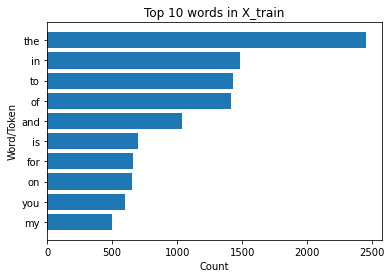

In [19]:
plot_top_words(train_freq_dist, title='Top 10 words in X_train', cutoff=10)

In [20]:
# This list is mainly of stopwords. We'll remove them eventually. First let's get to a baseline model.

In [21]:
# Getting to a baseline model

In [22]:
tfidf = TfidfVectorizer(max_features=10, tokenizer=tokenizer.tokenize)

X_train_vectorized = tfidf.fit_transform(X_train['text_tokenized'].apply(lambda x: ' '.join(x)))

# Inspect
pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index)

,and,for,in,is,my,of,on,the,to,you
5372,0.000000,0.000000,0.306130,0.397168,0.000000,0.000000,0.000000,0.806059,0.314343,0.000000
1707,0.000000,0.000000,0.569644,0.000000,0.821892,0.000000,0.000000,0.000000,0.000000,0.000000
4100,0.860773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330713,0.386910,0.000000
4394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5728,0.000000,0.414651,0.317096,0.000000,0.000000,0.646287,0.000000,0.556622,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2574,0.752392,0.000000,0.658715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.832760,0.553634,0.000000,0.000000
6069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6062,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
baseline_model = MultinomialNB()
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)

In [24]:
print(f'Baseline model ---- mean of CV scores: {np.mean(baseline_cv):.5f}')

Baseline model ---- mean of CV scores: 0.62025


In [25]:
y_train.value_counts(normalize=True)

0    0.569802
1    0.430198
Name: target, dtype: float64

In [26]:
# Beats a dummy classifier, but still not great.
# Removing stopwords

In [27]:
stopword_list = stopwords.words('english')

In [28]:
X_train['text_tokenized_no_sw'] = X_train['text_tokenized'].apply(lambda x: [w for w in x if not w in stopword_list])
X_train['text_no_sw'] = X_train['text_tokenized_no_sw'].apply(lambda x: ' '.join(x))

In [29]:
X_train.head()

,had_url,text,text_tokenized,text_tokenized_no_sw,text_no_sw
5372,0,the good thing is that the #royals won't face a newbie in the playoffs. no real reason to panic.,"[the, good, thing, is, that, the, royals, won't, face, newbie, in, the, playoffs, no, real, reas...","[good, thing, royals, face, newbie, playoffs, real, reason, panic]",good thing royals face newbie playoffs real reason panic
1707,1,i scored 111020 points in punch quest stopped when a squeaky bat collided into my skull.,"[scored, 111020, points, in, punch, quest, stopped, when, squeaky, bat, collided, into, my, skull]","[scored, 111020, points, punch, quest, stopped, squeaky, bat, collided, skull]",scored 111020 points punch quest stopped squeaky bat collided skull
4100,1,kevin tan says hail to the chefs - û_ and green pastures which features sustainable and organic...,"[kevin, tan, says, hail, to, the, chefs, and, green, pastures, which, features, sustainable, and...","[kevin, tan, says, hail, chefs, green, pastures, features, sustainable, organic, cooking]",kevin tan says hail chefs green pastures features sustainable organic cooking
4394,1,#hot funtenna: hijacking computers to send data as sound waves [black hat 2015] #prebreak #best,"[hot, funtenna, hijacking, computers, to, send, data, as, sound, waves, black, hat, 2015, prebre...","[hot, funtenna, hijacking, computers, send, data, sound, waves, black, hat, 2015, prebreak, best]",hot funtenna hijacking computers send data sound waves black hat 2015 prebreak best
5728,0,rescuers are searching for hundreds of migrants in the mediterranean after a boat carrying as ma...,"[rescuers, are, searching, for, hundreds, of, migrants, in, the, mediterranean, after, boat, car...","[rescuers, searching, hundreds, migrants, mediterranean, boat, carrying, many, 600, people, caps...",rescuers searching hundreds migrants mediterranean boat carrying many 600 people capsized coast


In [30]:
train_freq_dist = FreqDist(X_train['text_tokenized_no_sw'].explode())

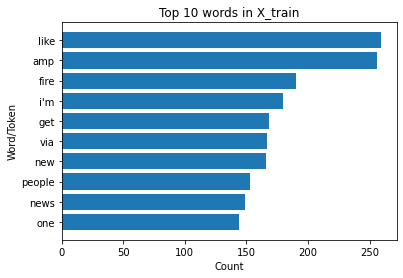

In [31]:
plot_top_words(train_freq_dist, title='Top 10 words in X_train', cutoff=10)

In [32]:
tfidf = TfidfVectorizer(max_features=10, tokenizer=tokenizer.tokenize, stop_words=stopword_list)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index)

,amp,fire,get,i'm,like,new,news,one,people,via
5372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3484,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'amp' is an artifact of '&amp;', which is HTML code for an ampersand.

It shouldn't be in my top 10 words, so I'll add it to my stopwords before proceeding.

I also think "i'm" should be considered a stopword

In [33]:
stopword_list.extend(['amp', "i'm"])

In [34]:
X_train['text_tokenized_no_sw'] = X_train['text_tokenized'].apply(lambda x: [w for w in x if not w in stopword_list])
X_train['text_no_sw'] = X_train['text_tokenized_no_sw'].apply(lambda x: ' '.join(x))

In [35]:
X_train.head()

,had_url,text,text_tokenized,text_tokenized_no_sw,text_no_sw
5372,0,the good thing is that the #royals won't face a newbie in the playoffs. no real reason to panic.,"[the, good, thing, is, that, the, royals, won't, face, newbie, in, the, playoffs, no, real, reas...","[good, thing, royals, face, newbie, playoffs, real, reason, panic]",good thing royals face newbie playoffs real reason panic
1707,1,i scored 111020 points in punch quest stopped when a squeaky bat collided into my skull.,"[scored, 111020, points, in, punch, quest, stopped, when, squeaky, bat, collided, into, my, skull]","[scored, 111020, points, punch, quest, stopped, squeaky, bat, collided, skull]",scored 111020 points punch quest stopped squeaky bat collided skull
4100,1,kevin tan says hail to the chefs - û_ and green pastures which features sustainable and organic...,"[kevin, tan, says, hail, to, the, chefs, and, green, pastures, which, features, sustainable, and...","[kevin, tan, says, hail, chefs, green, pastures, features, sustainable, organic, cooking]",kevin tan says hail chefs green pastures features sustainable organic cooking
4394,1,#hot funtenna: hijacking computers to send data as sound waves [black hat 2015] #prebreak #best,"[hot, funtenna, hijacking, computers, to, send, data, as, sound, waves, black, hat, 2015, prebre...","[hot, funtenna, hijacking, computers, send, data, sound, waves, black, hat, 2015, prebreak, best]",hot funtenna hijacking computers send data sound waves black hat 2015 prebreak best
5728,0,rescuers are searching for hundreds of migrants in the mediterranean after a boat carrying as ma...,"[rescuers, are, searching, for, hundreds, of, migrants, in, the, mediterranean, after, boat, car...","[rescuers, searching, hundreds, migrants, mediterranean, boat, carrying, many, 600, people, caps...",rescuers searching hundreds migrants mediterranean boat carrying many 600 people capsized coast


In [36]:
train_freq_dist = FreqDist(X_train['text_tokenized_no_sw'].explode())

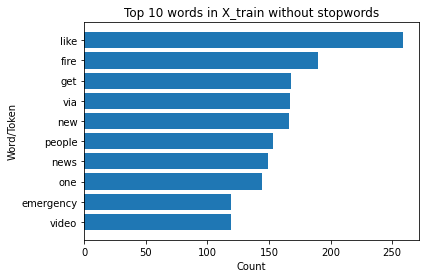

In [37]:
plot_top_words(train_freq_dist, title='Top 10 words in X_train without stopwords', cutoff=10)

In [38]:
tfidf = TfidfVectorizer(max_features=10, tokenizer=tokenizer.tokenize, stop_words=stopword_list)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index)

,emergency,fire,get,like,new,news,one,people,via,video
5372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
model_stopwords = MultinomialNB()
model_stopwords_cv = cross_val_score(model_stopwords, X_train_vectorized, y_train)

In [40]:
print(f'Baseline model ---- mean of CV scores: {np.mean(baseline_cv):.5f}')
print(f'Stopwords model ---- mean of CV scores: {np.mean(model_stopwords_cv):.5f}')

Baseline model ---- mean of CV scores: 0.62025
Stopwords model ---- mean of CV scores: 0.59503


In [41]:
# Somehow that's worse?

# Try increasing the number of tokens to 25

In [42]:
tfidf = TfidfVectorizer(max_features=25, tokenizer=tokenizer.tokenize, stop_words=stopword_list)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index)

,back,body,burning,california,crash,disaster,emergency,fire,get,got,...,one,people,police,still,storm,suicide,time,via,video,would
5372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
model_stopwords_25 = MultinomialNB()
model_stopwords_25_cv = cross_val_score(model_stopwords_25, X_train_vectorized, y_train)

In [44]:
print(f'Baseline model ---- mean of CV scores: {np.mean(baseline_cv):.5f}')
print(f'Stopwords model ---- mean of CV scores: {np.mean(model_stopwords_cv):.5f}')
print(f'Stopwords 25 model ---- mean of CV scores: {np.mean(model_stopwords_25_cv):.5f}')

Baseline model ---- mean of CV scores: 0.62025
Stopwords model ---- mean of CV scores: 0.59503
Stopwords 25 model ---- mean of CV scores: 0.63952


In [45]:
# Marginally better than baseline. What about adding the `had_url` feature?

In [46]:
X_train_vectorized_df = pd.DataFrame(
    X_train_vectorized.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index
)
preprocessed_X_train = pd.concat(
    [X_train_vectorized_df, X_train[["had_url"]]], 
    axis=1
)
preprocessed_X_train

,back,body,burning,california,crash,disaster,emergency,fire,get,got,...,people,police,still,storm,suicide,time,via,video,would,had_url
5372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [47]:
model_stopwords_urls = MultinomialNB()
model_stopwords_urls_cv = cross_val_score(model_stopwords_urls, preprocessed_X_train, y_train)

In [48]:
print(f'Baseline model ---- mean of CV scores: {np.mean(baseline_cv):.5f}')
print(f'Stopwords model ---- mean of CV scores: {np.mean(model_stopwords_cv):.5f}')
print(f'Stopwords 25 model ---- mean of CV scores: {np.mean(model_stopwords_25_cv):.5f}')
print(f'Stopwords URLs model ---- mean of CV scores: {np.mean(model_stopwords_urls_cv):.5f}')

Baseline model ---- mean of CV scores: 0.62025
Stopwords model ---- mean of CV scores: 0.59503
Stopwords 25 model ---- mean of CV scores: 0.63952
Stopwords URLs model ---- mean of CV scores: 0.64022


In [49]:
# Again, just barely better

In [51]:
# stem and lemmatize
# bigrams
# Pointwise Mutual Information Score
# more tokens
# max and min df
# Other models
